In [1]:
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import IPython
import gc
import torch.nn.functional as F
import torchaudio.transforms as tt
import matplotlib
import matplotlib.pyplot as plt
import wandb
import random
import torch.optim as optim
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset

from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections

%matplotlib inline

wandb.login(key = os.environ["WANDB_API_KEY"])

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


wandb: Currently logged in as: luquishh (luquishh-universidad-torcuato-di-tella). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lucamazzarello_/.netrc


True

# TP3: Encodeador de música

### Visualización de los archivos

In [2]:
project_name='Trabajo_Practico_3_Music_Genre_Classification'
samplerate=22050

In [3]:
data_dir='/Users/lucamazzarello_/Desktop/Repositories/TP3_TD6/genres_5sec'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['pop',
 'metal',
 'disco',
 'blues',
 'reggae',
 'classical',
 'rock',
 'hiphop',
 'country',
 'jazz']

In [4]:
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]

        #img = self.transform(open_image(fpath))
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]

        return audio, class_idx
        
dataset = MusicDataset(data_dir)

In [5]:
waveform,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 3 


shape of spectogram torch.Size([1, 201, 552])


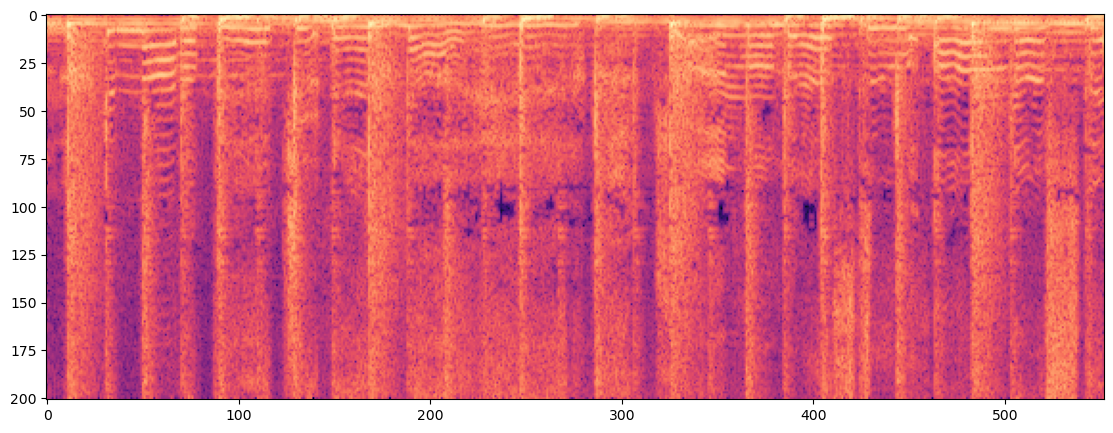

In [6]:
specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

Waveform: tensor([[ 0.0345,  0.0482,  0.0643,  ..., -0.1070, -0.0598, -0.0341]])



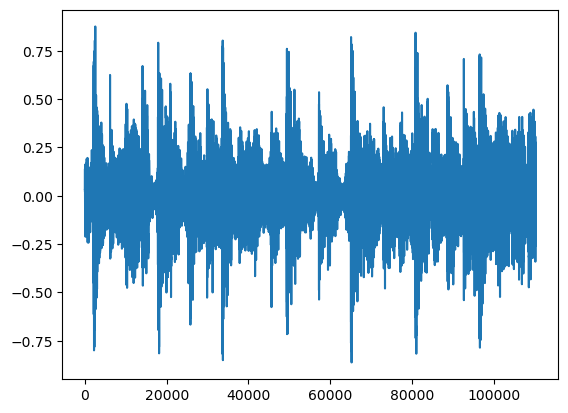

In [7]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

In [8]:
IPython.display.Audio(waveform,rate=samplerate)

In [9]:
specgram.size()

torch.Size([1, 201, 552])

### **Creación de los conjuntos**

In [10]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Adicional.
    transforms.ToTensor(),             # Convierte las imágenes a tensores de PyTorch, en el caso de que todavía no lo sean.
    transforms.Normalize(0, 1)         # Adicional.
])

val_test_transform = transforms.Compose([
    # Acá no aplicamos RandomHorizontalFlip, porque ya no estamos en entrenamiento.
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

In [11]:
random_seed = 43992294
batch_size = 20

torch.manual_seed(random_seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [12]:
def stratify_split(dataset: Dataset, classes: list[int]):
    
    train_indices = []
    val_indices = []
    test_indices = []

    NUM_CLASSES = len(classes)
    total_samples = len(dataset)
    
    # Calcular el número de muestras para cada conjunto
    train_samples = int(total_samples * 0.8)
    val_samples = int(total_samples * 0.1)
    test_samples = total_samples - train_samples - val_samples  # Resto para test

    train_samples_per_class = train_samples // NUM_CLASSES
    val_samples_per_class = val_samples // NUM_CLASSES
    test_samples_per_class = test_samples // NUM_CLASSES

    train_target_counter = collections.Counter()
    val_target_counter = collections.Counter()
    test_target_counter = collections.Counter()

    for idx, data in enumerate(dataset):
        target = data[1]
        if train_target_counter[target] < train_samples_per_class:
            train_indices.append(idx)
            train_target_counter[target] += 1
        elif val_target_counter[target] < val_samples_per_class:
            val_target_counter[target] += 1
            val_indices.append(idx)
        elif test_target_counter[target] < test_samples_per_class:
            test_target_counter[target] += 1
            test_indices.append(idx)

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

In [13]:
trainset, valset, testset = stratify_split(dataset, classes)

trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
valloader = DataLoader(valset, batch_size = batch_size, shuffle = False)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = False)

In [14]:
len(testloader), len(valloader), len(trainloader)

(5, 5, 40)

### Clasificación

In [15]:
class MLP(nn.Module):
    def __init__(self, n_input, hidden_layers=2, nodes=64, n_output=10, activation_choices=None, dropout_rate=0.2):
        super(MLP, self).__init__()
        
        # Definición de capas
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        # Primera capa oculta
        self.layers.append(nn.Linear(n_input, nodes))
        
        # Añadir capas ocultas
        for _ in range(hidden_layers - 1):
            self.layers.append(nn.Linear(nodes, nodes))
        
        self.output_layer = nn.Linear(nodes, n_output)
        
        # Lista de funciones de activación disponibles
        if activation_choices is None:
            activation_choices = [F.relu, F.tanh, F.leaky_relu, F.sigmoid]
        
        # Elegir funciones de activación aleatorias
        self.activations = [random.choice(activation_choices) for _ in range(hidden_layers)]

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.dropout(x)
            x = self.activations[i](x)
        x = self.output_layer(x)
        return F.log_softmax(x, dim=1)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 
                      'cpu')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
# Limpiar caché de CUDA y recolectar basura
torch.cuda.empty_cache()
gc.collect()  # Importante para liberar memoria RAM

num_epochs = 5
n_input = 110250
best_valid_loss = float('inf')
worst_valid_loss = float('-inf')
best_experiment = None
worst_experiment = None

# Define a list of hyperparameter configurations
hyperparameter_configs = [
    {"learning_rate": 0.0001, "batch_size": 16, "hidden_layers": 2, "nodes": 64, "dropout": 0.2},
    {"learning_rate": 0.0005, "batch_size": 32, "hidden_layers": 3, "nodes": 128, "dropout": 0.3},
    {"learning_rate": 0.001, "batch_size": 64, "hidden_layers": 4, "nodes": 256, "dropout": 0.4},
]

for config in hyperparameter_configs:
    # Generar un nombre para el experimento basado en los hiperparámetros
    experiment_name = f"lr_{config['learning_rate']}_bs_{config['batch_size']}_hl_{config['hidden_layers']}_nodes_{config['nodes']}_dropout_{config['dropout']}"

    # Inicializar W&B para cada configuración
    wandb.init(project=project_name, name=experiment_name, config=config)
    
    # Extraer hiperparámetros de la configuración
    learning_rate = config["learning_rate"]
    batch_size = config["batch_size"]
    hidden_layers = config["hidden_layers"]
    nodes = config["nodes"]
    dropout_rate = config["dropout"]  # Nueva tasa de Dropout
    
    # Inicializar el modelo con los hiperparámetros actuales
    model = MLP(n_input=n_input, hidden_layers=hidden_layers, nodes=nodes, n_output=len(classes), dropout_rate=dropout_rate).to(device)
    print(model)

    # Contar parámetros
    n = count_parameters(model)
    print("Number of parameters: %s" % n)

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    valid_losses = []

    # Inicializar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Inicializar el scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    losses = []

    # Entrenamiento
    model.train()
    for wav, genre_index in trainloader:
        optimizer.zero_grad()  # Limpiar gradientes
        wav = wav.to(device)
        genre_index = torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(wav)
        loss = loss_function(out.squeeze(), genre_index)

        # Backward
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Registrar la pérdida de entrenamiento en W&B
        wandb.log({"train_loss": loss.item()})

    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch + 1, num_epochs, np.mean(losses)))

    # Validación
    model.eval()
    y_true = []
    y_pred = []
    losses = []
    correct = 0
    for wav, genre_index in valloader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        out = model(wav)
        loss = loss_function(out.squeeze(), genre_index)

        losses.append(loss.item())
        pred = out.argmax(dim=-1).flatten()
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

    accuracy = correct / len(valloader.dataset)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch + 1, num_epochs, valid_loss, accuracy))

    # Registrar métricas de validación en W&B
    wandb.log({"valid_loss": valid_loss, "valid_accuracy": accuracy})

    # Ajustar la tasa de aprendizaje
    scheduler.step(valid_loss)  # Actualizar el scheduler

    # Guardar modelo
    valid_losses.append(valid_loss.item())
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_experiment = config
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(model.state_dict(), 'best_model.ckpt')

    if valid_loss > worst_valid_loss:
        worst_valid_loss = valid_loss
        worst_experiment = config

        # Finalizar la ejecución de W&B
        wandb.finish()  

    # Reportar los mejores y peores experimentos
print("Best Experiment Configuration:", best_experiment)
print("Worst Experiment Configuration:", worst_experiment)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=110250, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
)
Number of parameters: 7060874


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MLP(
  (layers): ModuleList(
    (0): Linear(in_features=110250, out_features=128, bias=True)
    (1-2): 2 x Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
)
Number of parameters: 14146442


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MLP(
  (layers): ModuleList(
    (0): Linear(in_features=110250, out_features=256, bias=True)
    (1-3): 3 x Linear(in_features=256, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
)
Number of parameters: 28424202
Epoch: [1/5], Train loss: 2.3026
Epoch: [1/5], Valid loss: 2.3026, Valid accuracy: 0.1000
Saving the best model at 0 epochs!


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,▁
valid_loss,▁
train_loss,2.30259
valid_accuracy,0.1
valid_loss,2.30259


Error: You must call wandb.init() before wandb.log()